<a href="https://colab.research.google.com/github/mlvssyaswanth/colab-files/blob/main/sc1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define path to the ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/archive.zip"  # Change this if your ZIP file is in a different location
extract_dir = "/content/HAM10000"

# Check if the ZIP file exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at {zip_path}. Please check the path.")

# Extract the ZIP file if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")


Dataset extracted successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Define metadata CSV file path
metadata_path = os.path.join(extract_dir, "HAM10000_metadata.csv")

# Load dataset metadata into a Pandas DataFrame
df = pd.read_csv(metadata_path)

# Display first 5 rows
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Function to find correct image path
def get_image_path(image_id):
    part1 = os.path.join(extract_dir, "HAM10000_images_part_1", f"{image_id}.jpg")
    part2 = os.path.join(extract_dir, "HAM10000_images_part_2", f"{image_id}.jpg")
    return part1 if os.path.exists(part1) else part2

# Add image paths to DataFrame
df["image_path"] = df["image_id"].apply(get_image_path)

# Display updated DataFrame
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/HAM10000/HAM10000_images_part_1/ISIC_...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/HAM10000/HAM10000_images_part_2/ISIC_...


In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 128  # Resize images to 128x128
images, labels = [], []

# Loop through each row and load images
for _, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row['image_path'])  # Load image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
    img = img / 255.0  # Normalize pixel values (0-1)

    images.append(img)
    labels.append(row['dx'])  # 'dx' is the diagnosis label

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images.")

100%|██████████| 10015/10015 [01:14<00:00, 134.03it/s]


Loaded 10015 images.


In [ ]:
IMG_SIZE = 128  # Resize images to 128x128
images, labels = [], []

# Limit the number of images to 3000
num_images = min(6000, len(df))

# Loop through each row and load images
for _, row in tqdm(df.iterrows(), total=num_images):
    if len(images) >= num_images:
        break  # Stop processing after 3000 images

    img = cv2.imread(row['image_path'])  # Load image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
    img = img / 255.0  # Normalize pixel values (0-1)

    images.append(img)
    labels.append(row['dx'])  # 'dx' is the diagnosis label

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images.")

100%|██████████| 6000/6000 [00:44<00:00, 133.60it/s]


Loaded 6000 images.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels (diagnoses) to numbers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 4800, Testing samples: 1200


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(labels)), activation='softmax')  # Output layer
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,314,182 (12.64 MB)

 Trainable params: 3,313,734 (12.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.5867 - loss: 2.7731 - val_accuracy: 0.6100 - val_loss: 1.4198
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6411 - loss: 1.3550 - val_accuracy: 0.4767 - val_loss: 1.4651
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6757 - loss: 0.9589 - val_accuracy: 0.5892 - val_loss: 1.0844
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6696 - loss: 0.9783 - val_accuracy: 0.7350 - val_loss: 0.8759
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6820 - loss: 0.8520 - val_accuracy: 0.5383 - val_loss: 1.3674
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7142 - loss: 0.7720 - val_accuracy: 0.7342 - val_loss: 0.8140
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7200 - loss: 0.7313 - val_accuracy: 0.6483 - val_loss: 1.1197
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7565 - loss: 0.6620 - val_ac

In [ ]:
# Evaluate model on test data
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5938 - loss: 1.2961
Test Accuracy: 60.75%


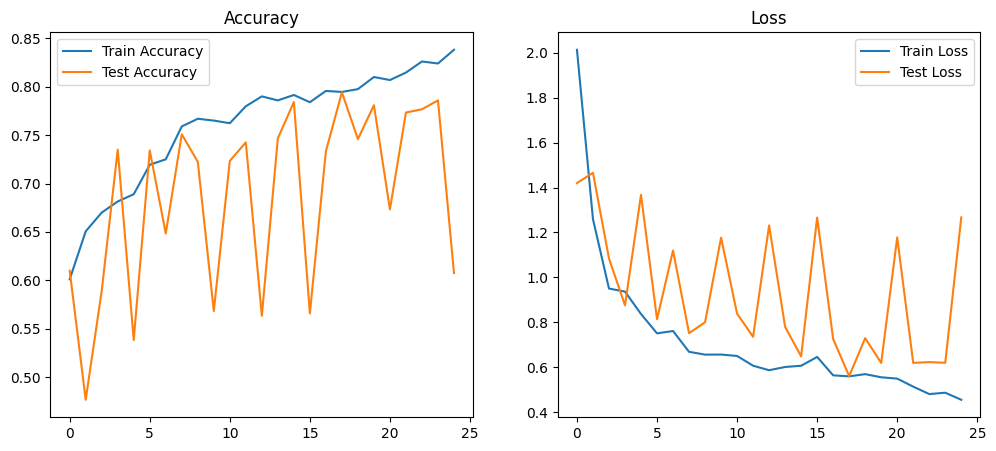

In [ ]:
import matplotlib.pyplot as plt

# Plot training accuracy & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss")

plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


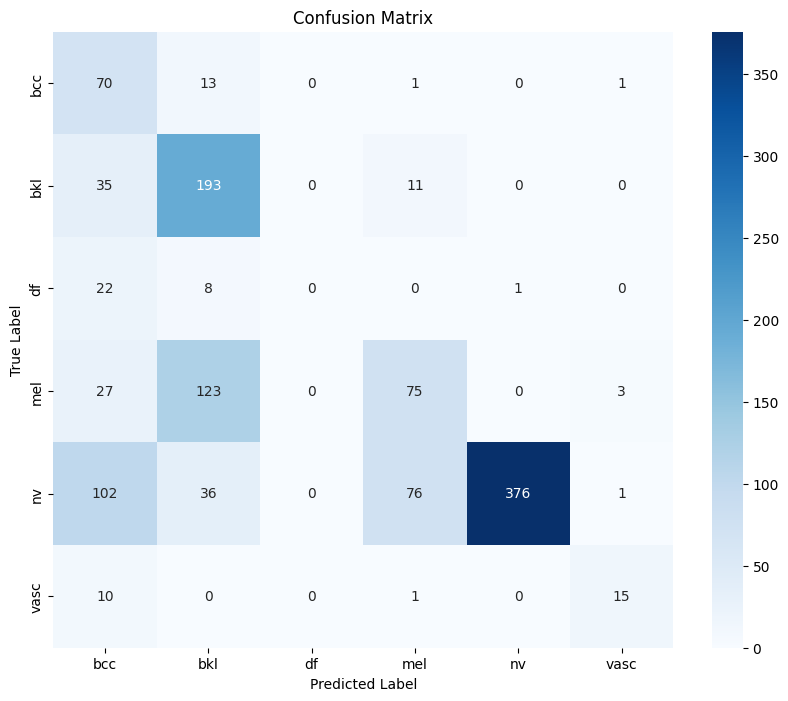

Classification Report:
              precision    recall  f1-score   support

         bcc       0.26      0.82      0.40        85
         bkl       0.52      0.81      0.63       239
          df       0.00      0.00      0.00        31
         mel       0.46      0.33      0.38       228
          nv       1.00      0.64      0.78       591
        vasc       0.75      0.58      0.65        26

    accuracy                           0.61      1200
   macro avg       0.50      0.53      0.47      1200
weighted avg       0.72      0.61      0.62      1200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


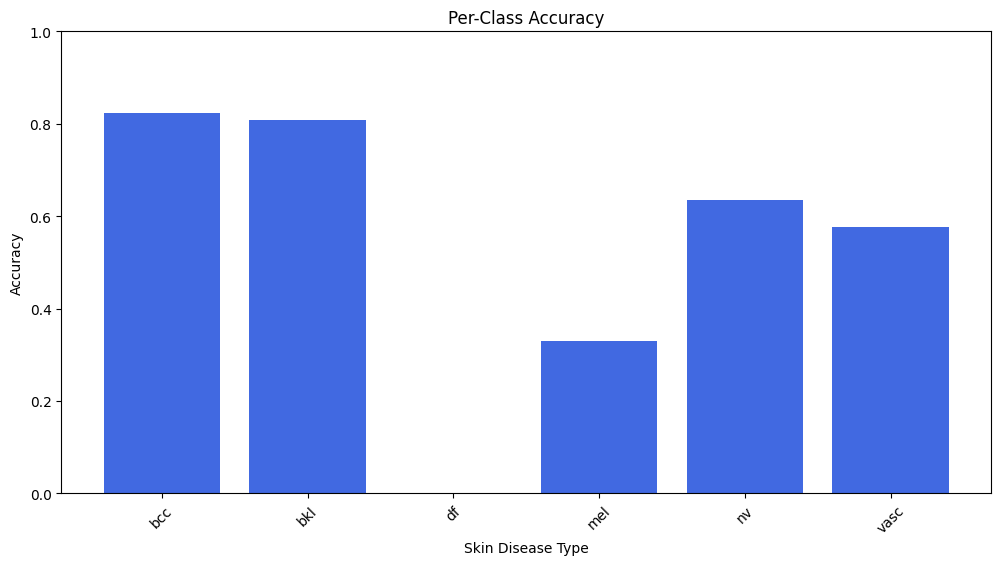

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute per-class accuracy
class_correct = np.diagonal(conf_matrix)
class_total = np.sum(conf_matrix, axis=1)
class_accuracy = class_correct / class_total

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(label_encoder.classes_, class_accuracy, color='royalblue')
plt.xlabel("Skin Disease Type")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


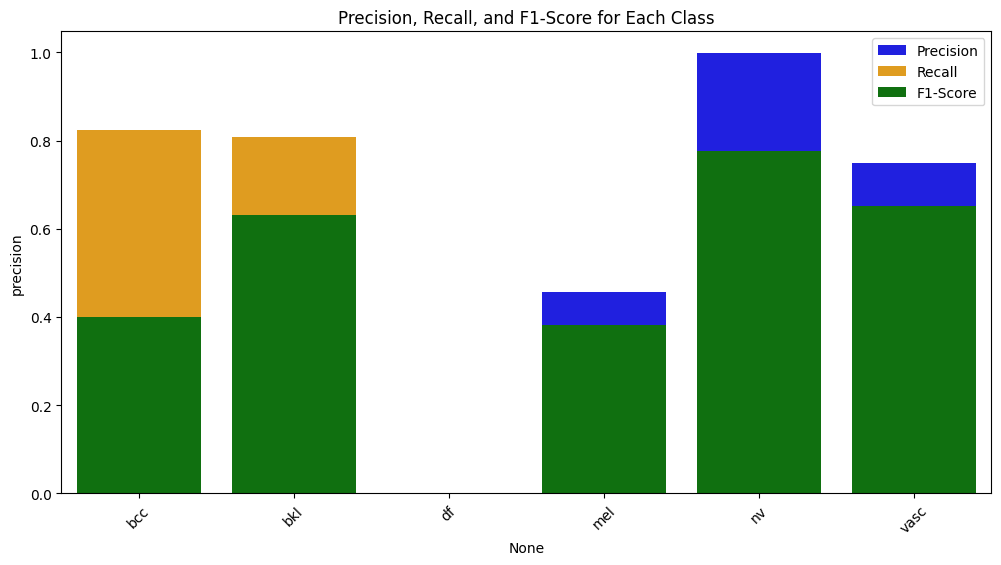

In [ ]:
import seaborn as sns

# Get classification report as a dictionary
report_dict = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Plot precision, recall, and f1-score
plt.figure(figsize=(12, 6))
sns.barplot(x=report_df.index[:-3], y=report_df["precision"][:-3], color='blue', label="Precision")
sns.barplot(x=report_df.index[:-3], y=report_df["recall"][:-3], color='orange', label="Recall")
sns.barplot(x=report_df.index[:-3], y=report_df["f1-score"][:-3], color='green', label="F1-Score")

plt.xticks(rotation=45)
plt.legend()
plt.title("Precision, Recall, and F1-Score for Each Class")
plt.show()


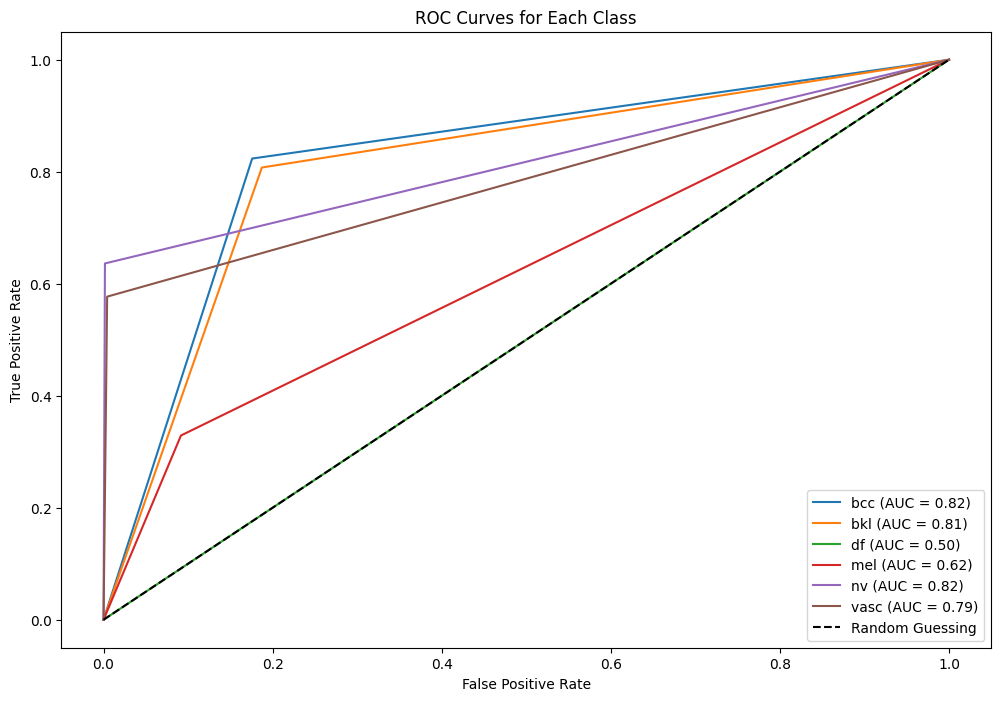

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert labels to one-hot encoding
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
y_pred_bin = label_binarize(y_pred_classes, classes=np.arange(len(label_encoder.classes_)))

plt.figure(figsize=(12, 8))

# Plot ROC curve for each class
for i, label in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.show()


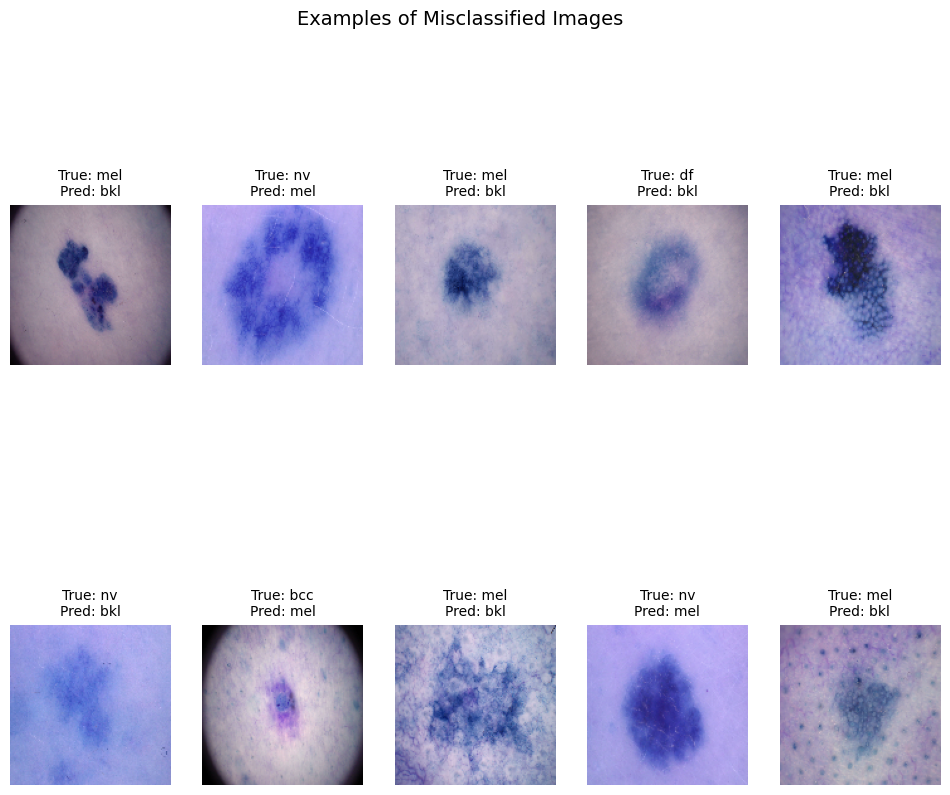

In [ ]:
misclassified_idxs = np.where(y_pred_classes != y_test)[0]

# Select 10 misclassified images
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idxs[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.axis("off")
    true_label = label_encoder.classes_[y_test[idx]]
    pred_label = label_encoder.classes_[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
plt.suptitle("Examples of Misclassified Images", fontsize=14)
plt.show()

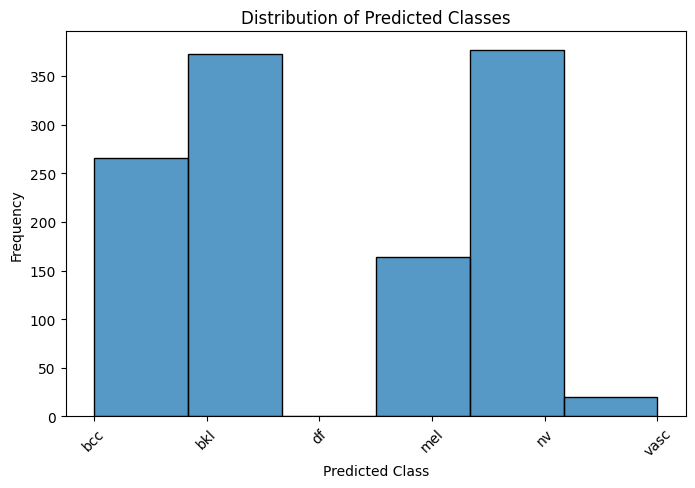

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y_pred_classes, bins=len(label_encoder.classes_), kde=False)
plt.xticks(ticks=np.arange(len(label_encoder.classes_)), labels=label_encoder.classes_, rotation=45)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Classes")
plt.show()

In [ ]:
model.save("/content/model.keras")